# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 30.01.2025

Мягкий дедлайн: 23:59MSK 16.02.2025

Жесткий дедлайн: 23:59MSK 23.02.2025

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Использование генеративных языковых моделей разрешено только в случае явного указания на это. Необходимо прописать (в соответствующих пунктах, где использовались, либо в начале/конце работы):
- какая языковая модель использовалась
- какие использовались промпты и в каких частях работы
- с какими сложностями вы столкнулись при использовании генеративных моделей, с чем они помогли больше всего

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

In [1]:
%load_ext autoreload
%autoreload 2

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [2]:
import numpy as np

# 1 Способ
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()

# 2 Способ (если первый не работает)
# from sklearn.datasets import fetch_openml
# def load_fashion_mnist():
#     X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
#     X = X.reshape(-1, 28, 28).astype('uint8')
#     y = y.astype('int64')
#     x_train, x_test = X[:60000], X[60000:]
#     y_train, y_test = y[:60000], y[60000:]
#     return (x_train, y_train), (x_test, y_test)
# (x_train_pics, y_train), (x_test_pics, y_test) = load_fashion_mnist()




x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

__Задание 0. (0.25 баллов)__

**Вопрос:** зачем в алгоритме нужен метод главных компонент?

**Ответ:** Метод главных компонент используется в данном алгоритме для понижения размерности выборки, что позволяет уменьшить количество признаков в исходных данных перед применением дальнейших шагов, благодаря чему:

Снижаются вычислительные затраты, так как количество признаков становится меньше, следовательно требуется меньше вычислений в RFF.

Сохраняется наиболее важная информация, потому что МГК оставляет наиболее важные компоненты, которые объясняют максимальную дисперсию в данных, следовательно эффективность алгоритма RFF повышается.

Снижается шум, так как уменьшается количество неинформативных признаков, тем самым растет качество алгоритма RFF.


__Задание 1. (3 балла)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса в `homework_practice_08_rff.py` (допишите его и исправьте несостыковки в классе пайплайна) или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [73]:
from collections import UserDict
import numpy as np

from typing import Callable

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from math import pi
from scipy.stats import chi


class FeatureCreatorPlaceholder(BaseEstimator, TransformerMixin):
    def __init__(self, n_features, new_dim, func: Callable = np.cos):
        self.n_features = n_features
        self.new_dim = new_dim
        self.w = None
        self.b = None
        self.func = func

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X


class RandomFeatureCreator(FeatureCreatorPlaceholder):
    def fit(self, X, y=None):
        n_samples = X.shape[0]
        sample_indices = np.random.choice(n_samples, size=(1000000, 2), replace=True)
        distances = np.sum((X[sample_indices[:, 0]] - X[sample_indices[:, 1]]) ** 2, axis=1)
        sigma = np.sqrt(np.median(distances))
        self.w = np.random.normal(loc=0, scale=1/sigma, size=(self.n_features, X.shape[1]))
        self.b = np.random.uniform(low=-pi, high=pi, size=self.n_features)
        return self

    def transform(self, X, y=None):
        return self.func(X @ self.w.T + self.b)


class OrthogonalRandomFeatureCreator(RandomFeatureCreator):
    def fit(self, X, y=None):
        n_samples = X.shape[0]
        sample_indices = np.random.choice(n_samples, size=(1000000, 2), replace=True)
        distances = np.sum((X[sample_indices[:, 0]] - X[sample_indices[:, 1]]) ** 2, axis=1)
        sigma = np.sqrt(np.median(distances))

        G = np.random.normal(0, 1, (self.n_features, X.shape[1]))
        Q, _ = np.linalg.qr(G)
        S = np.diag(chi.rvs(df=self.n_features, size=self.n_features))
        self.w = 1/sigma * S @ Q
        self.b = np.random.uniform(low=-pi, high=pi, size=self.n_features)
        return self

    def transform(self, X, y=None):
        if self.n_features < X.shape[1]:
            X = X[:, :self.n_features]
        return self.func(X @ self.w.T + self.b)

class RandomBinningFeatureCreator(FeatureCreatorPlaceholder):
  def fit(self, X, y=None):
        self.n_samples, self.new_dim = X.shape
        self.deltas = np.array([np.random.gamma(shape=2, scale=1.0) for _ in range(self.new_dim)])
        self.us = np.array([np.random.uniform(low=0.0, high=delta) for delta in self.deltas])
        return self

  def transform(self, X, y=None):
        Z = []
        for i in range(self.n_samples):
            z = []
            x = X[i]
            for p in range(self.n_features):

                z_p = np.ceil((x - self.us) / self.deltas).astype(int)
                z.append(z_p)
            Z.append(np.concatenate(z))
        return (np.array(Z))/np.sqrt(self.n_features)

class RFFPipeline(BaseEstimator):
    """
    Пайплайн, делающий последовательно три шага:
        1. Применение PCA
        2. Применение RFF
        3. Применение классификатора
    """
    def __init__(
            self,
            n_features: int = 1000,
            new_dim: int = 50,
            use_PCA: bool = True,
            feature_creator_class=FeatureCreatorPlaceholder,
            classifier_class=LogisticRegression,
            classifier_params=None,
            func=np.cos,
    ):
        """
        :param n_features: Количество признаков, генерируемых RFF
        :param new_dim: Количество признаков, до которых сжимает PCA
        :param use_PCA: Использовать ли PCA
        :param feature_creator_class: Класс, создающий признаки, по умолчанию заглушка
        :param classifier_class: Класс классификатора
        :param classifier_params: Параметры, которыми инициализируется классификатор
        :param func: Функция, которую получает feature_creator при инициализации.
                     Если не хотите, можете не использовать этот параметр.
        """
        self.n_features = n_features
        self.new_dim = new_dim
        self.use_PCA = use_PCA
        if classifier_params is None:
            classifier_params = {}
        self.classifier_class = classifier_class
        self.classifier_params = classifier_params
        self.classifier = self.classifier_class(**self.classifier_params)
        self.feature_creator_class = feature_creator_class
        self.func = func
        self.feature_creator = self.feature_creator_class(
            n_features=self.n_features, new_dim=self.new_dim, func=self.func
        )
        self.pca = PCA(n_components=self.new_dim) if use_PCA else None

    def fit(self, X, y):
        if self.use_PCA:
            X = self.pca.fit_transform(X)

        self.feature_creator.fit(X)
        X_new = self.feature_creator.transform(X)
        self.classifier.fit(X_new, y)
        return self

    def predict_proba(self, X):
        if self.use_PCA:
            X = self.pca.transform(X)

        X_new = self.feature_creator.transform(X)
        return self.classifier.predict_proba(X_new)

    def predict(self, X):
        if self.use_PCA:
            X = self.pca.transform(X)

        X_new = self.feature_creator.transform(X)
        return self.classifier.predict(X_new)

**Гиперпараметры по умолчанию:**

In [ ]:
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке: 85.83%


**Другие значения n_features и new_dim:**

In [ ]:
pipeline = RFFPipeline(n_features=100, new_dim=150, feature_creator_class=RandomFeatureCreator)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке: 82.55%


**Без предварительного понижения размерности с помощью МГК:**

In [ ]:
pipeline = RFFPipeline(n_features=1000, new_dim=100, feature_creator_class=RandomFeatureCreator, use_PCA=False)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке: 11.12%


**Другой тип линейной модели:**

In [ ]:
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator, classifier_class=LinearSVC)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке: 87.74%


__Задание 2. (2.5 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучите градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

**Подход со случайными признаками:**

*Логистическая регрессия:*

In [ ]:
import time

pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator)

start_time = time.time()
pipeline.fit(x_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = pipeline.predict(x_test)
prediction_time = time.time() - start_time

accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')
print(f'Время обучения: {round(training_time, 2)} сек')
print(f'Время применения: {round(prediction_time, 2)} сек')

Доля верных ответов на тестовой выборке: 85.89%
Время обучения: 59.79 сек
Время применения: 0.49 сек


*Линейный SVM:*

In [ ]:
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator, classifier_class=LinearSVC)

start_time = time.time()
pipeline.fit(x_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = pipeline.predict(x_test)
prediction_time = time.time() - start_time

accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')
print(f'Время обучения: {round(training_time, 2)} сек')
print(f'Время применения: {round(prediction_time, 2)} сек')

Доля верных ответов на тестовой выборке: 87.74%
Время обучения: 515.0 сек
Время применения: 0.45 сек


**Линейный SVM на исходных признаках:**

In [ ]:
linear_svm = LinearSVC()

start_time = time.time()
linear_svm.fit(x_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = linear_svm.predict(x_test)
prediction_time = time.time() - start_time

accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')
print(f'Время обучения: {round(training_time, 2)} сек')
print(f'Время применения: {round(prediction_time, 2)} сек')

Доля верных ответов на тестовой выборке, 83.78%
Время обучения, 2487.8 сек
Время применения, 0.05 сек


**Ядровой SVM на исходных признаках:**

In [ ]:
kernel_svm = SVC(kernel='rbf')

start_time = time.time()
kernel_svm.fit(x_train, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = kernel_svm.predict(x_test)
prediction_time = time.time() - start_time

accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')
print(f'Время обучения: {round(training_time, 2)} сек')
print(f'Время применения: {round(prediction_time, 2)} сек')

Доля верных ответов на тестовой выборке: 88.28%
Время обучения: 395.1 сек
Время применения: 199.67 сек


**Понижение размерность с помощью PCA + градиентный бустинг:**

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.4 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

cat_boost = CatBoostClassifier()

start_time = time.time()
cat_boost.fit(x_train_pca, y_train)
training_time = time.time() - start_time

start_time = time.time()
y_pred = cat_boost.predict(x_test_pca)
prediction_time = time.time() - start_time

accuracy = sum(y_pred.reshape(-1) == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')
print(f'Время обучения: {round(training_time, 2)} сек')
print(f'Время применения: {round(prediction_time, 2)} сек')

Learning rate set to 0.097501
0:	learn: 1.9693998	total: 117ms	remaining: 1m 56s
1:	learn: 1.7634667	total: 259ms	remaining: 2m 9s
2:	learn: 1.6184263	total: 384ms	remaining: 2m 7s
3:	learn: 1.5008601	total: 514ms	remaining: 2m 7s
4:	learn: 1.4062604	total: 625ms	remaining: 2m 4s
5:	learn: 1.3284877	total: 731ms	remaining: 2m 1s
6:	learn: 1.2621717	total: 839ms	remaining: 1m 59s
7:	learn: 1.2070214	total: 944ms	remaining: 1m 57s
8:	learn: 1.1516224	total: 1.05s	remaining: 1m 55s
9:	learn: 1.1044716	total: 1.16s	remaining: 1m 54s
10:	learn: 1.0622960	total: 1.26s	remaining: 1m 53s
11:	learn: 1.0269883	total: 1.37s	remaining: 1m 52s
12:	learn: 0.9924825	total: 1.47s	remaining: 1m 51s
13:	learn: 0.9596879	total: 1.58s	remaining: 1m 51s
14:	learn: 0.9370995	total: 1.68s	remaining: 1m 50s
15:	learn: 0.9138386	total: 1.79s	remaining: 1m 49s
16:	learn: 0.8925430	total: 1.89s	remaining: 1m 49s
17:	learn: 0.8706896	total: 2s	remaining: 1m 48s
18:	learn: 0.8502894	total: 2.1s	remaining: 1m 48s
1

**Вывод:**

In [ ]:
import pandas as pd

data = {'Model': ['LogisticRegression', 'Linear SVM', 'Linear SVM', 'Kernel SVM', 'CatBoost'],
        'Features': ['Random + PCA', 'Random + PCA', 'Original', 'Original', 'Original + PCA'],
        'Accuracy': [85.89, 87.74, 83.78, 88.28, 87.45],
        'Training_time': [59.79, 515, 2487.8, 395.10, 109.71],
        'Prediction_time': [0.49, 0.45, 0.05, 199.67, 0.15]}

df = pd.DataFrame(data)
df

,Model,Features,Accuracy,Training_time,Prediction_time
0,LogisticRegression,Random + PCA,85.89,59.79,0.49
1,Linear SVM,Random + PCA,87.74,515.00,0.45
2,Linear SVM,Original,83.78,2487.80,0.05
3,Kernel SVM,Original,88.28,395.10,199.67
4,CatBoost,Original + PCA,87.45,109.71,0.15


**Вывод:** По таблице видно, что лучшей по доле правильных ответов оказалась модель ядрового SVM с исходными признаками, за ней идет линейный SVM со случайными признаками, которая на 4% лучше линейного SVM с исходными признаками и чуть лучше градиентного бустинга. Логистическая регрессия со случайными признаками также показала результат на 2% выше, чем линейный SVM с исходными признаками, но хуже, чем остальные модели. В целом, с точки зрения качества, модели со случайными признаками показывают результаты выше, что подтверждается сравнением линейного SVM с исходными и случайными признаками.

Быстрее всего обучается модель логистической регрессии со случайными признаками, после него  идет градиентный бустинг с PCA. Дольше всего обучается линейный SVM с исходными признаками, но если использовать эту модель со случайными признаками и PCA, то время обучения падает в 5 раз.

Наибольшая скорость применения у линейного SVM с исходными признаками, затем идет градиентный бустинг, после этого модели со случайными признаками. В целом, время применения у всех моделей низкое, меньше полсекунды, кроме модели ядрового SVM, у которого применение 200 секунд.

Таким образом, использование случайных признаков и PCA, повышает качество снижает время обучения, но немного увеличивает время применения, что не так критично, так как значение меньше полсекунды.

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA?
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

**С использованием PCA:**

In [ ]:
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке, 85.63%


In [ ]:
pipeline = RFFPipeline(n_features=500, new_dim=50, feature_creator_class=RandomFeatureCreator)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке, 85.39%


**Без использования PCA:**

In [ ]:
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator, use_PCA = False)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке, 11.42%


In [ ]:
pipeline = RFFPipeline(n_features=500, new_dim=50, feature_creator_class=RandomFeatureCreator, use_PCA = False)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке, 11.18%


**1. Вывод:** предварительное понижение размерности с помощью PCA существенно помогает, так как доля верных ответов увеличивается примерно в 8 раз и составляет 85,5%. Без PCA доля верных ответов около 11%, что можно сравнить с угадыванием ответа.

**Зависимость итогового качества от n_features:**

In [ ]:
accuracies = []
for n_features in [1, 5, 10, 25, 50, 100, 250, 500, 750, 1000, 2500, 5000]:
    pipeline = RFFPipeline(n_features=n_features, new_dim=50, feature_creator_class=RandomFeatureCreator)
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    accuracy = sum(y_pred == y_test)/len(y_test)*100
    accuracies.append(accuracy)
    print(f'Доля верных ответов на тестовой выборке при n_features = {n_features}: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке при n_features = 1: 16.73%
Доля верных ответов на тестовой выборке при n_features = 5: 44.05%
Доля верных ответов на тестовой выборке при n_features = 10: 63.93%
Доля верных ответов на тестовой выборке при n_features = 25: 75.97%
Доля верных ответов на тестовой выборке при n_features = 50: 80.82%
Доля верных ответов на тестовой выборке при n_features = 100: 83.57%
Доля верных ответов на тестовой выборке при n_features = 250: 84.85%
Доля верных ответов на тестовой выборке при n_features = 500: 85.27%
Доля верных ответов на тестовой выборке при n_features = 750: 85.48%
Доля верных ответов на тестовой выборке при n_features = 1000: 85.93%
Доля верных ответов на тестовой выборке при n_features = 2500: 85.87%
Доля верных ответов на тестовой выборке при n_features = 5000: 85.97%


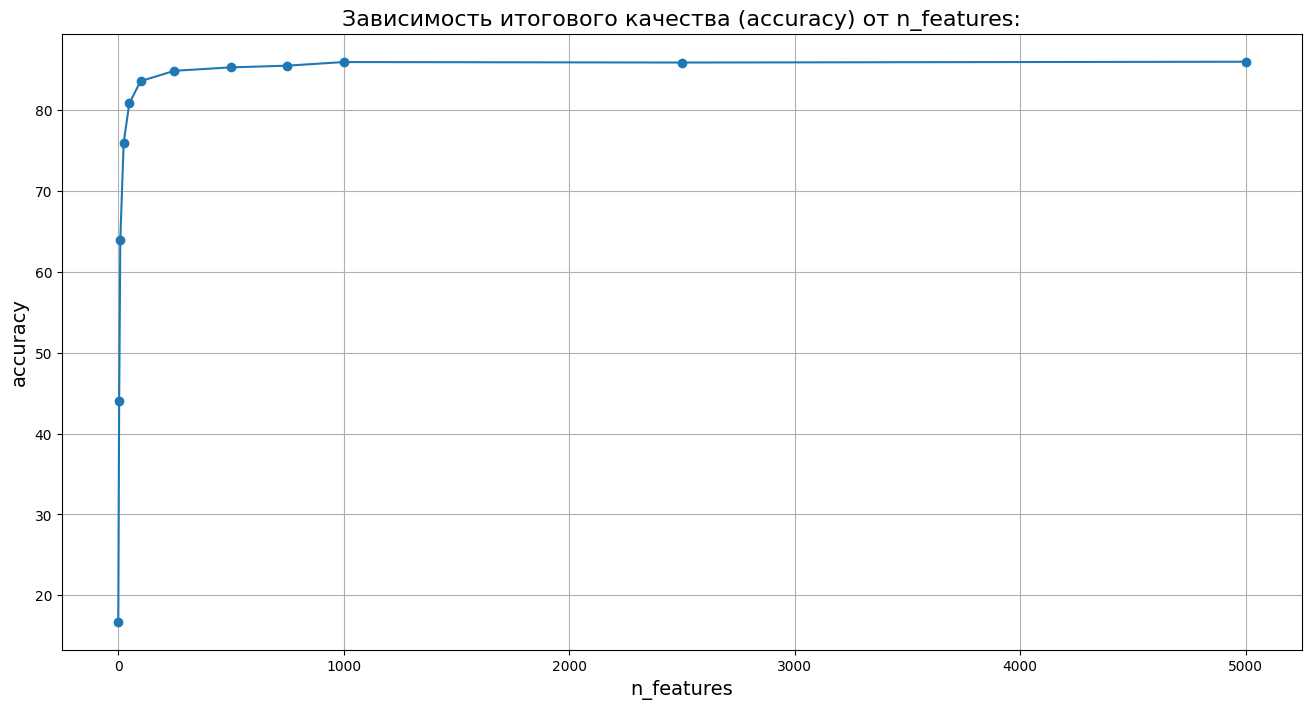

In [ ]:
import matplotlib.pyplot as plt
n_features = [1, 5, 10, 25, 50, 100, 250, 500, 750, 1000, 2500, 5000]

plt.figure(figsize=(16, 8))
plt.plot(n_features, accuracies, marker='o')

plt.title('Зависимость итогового качества (accuracy) от n_features:', fontsize=16)
plt.xlabel('n_features', fontsize=14)
plt.ylabel('accuracy', fontsize=14)

plt.grid(True)

**2. Вывод:** Сначала качество стремительно возрастает при росте n_features и преодолевает значение 80% при 100 признаках, после этого рост начинает замедляться все сильнее и сильнее и при 1000 признаках выходит на плато с качеством 85,9%.

**Модель логистической регрессии:**

In [ ]:
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке: 85.85%


In [ ]:
pipeline = RFFPipeline(n_features=500, new_dim=25, feature_creator_class=RandomFeatureCreator)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке: 84.2%


**Модель SVM:**

In [ ]:
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator, classifier_class=LinearSVC)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке: 88.14%


In [ ]:
pipeline = RFFPipeline(n_features=500, new_dim=25, feature_creator_class=RandomFeatureCreator, classifier_class=LinearSVC)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке: 86.49%


**3. Вывод:** Выбор модели важен, так как в проведенных экспериментах (также и в других заданиях) SVM показывает выше качество на 2-2.5%, чем логистическая регрессия.

__Задание 4. (Максимум 1.5 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет), n_features=new_dim и n_features < new_dim также должны работать, убедитесь в этом. Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.


**n_features > new_dim:**

*ORF:*

In [ ]:
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=OrthogonalRandomFeatureCreator)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке, 86.07%


*RRF:*

In [ ]:
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке, 86.0%


**n_features = new_dim:**

*ORF:*

In [ ]:
pipeline = RFFPipeline(n_features=100, new_dim=100, feature_creator_class=OrthogonalRandomFeatureCreator)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке, 83.61%


*RRF:*

In [ ]:
pipeline = RFFPipeline(n_features=100, new_dim=100, feature_creator_class=RandomFeatureCreator)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке, 82.84%


**n_features < new_dim:**

*ORF:*

In [ ]:
pipeline = RFFPipeline(n_features=100, new_dim=150, feature_creator_class=OrthogonalRandomFeatureCreator)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке, 83.93%


*RRF:*

In [ ]:
pipeline = RFFPipeline(n_features=100, new_dim=150, feature_creator_class=RandomFeatureCreator)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке, 82.2%


**Без предварительного понижения размерности с помощью МГК:**

*ORF:*

In [ ]:
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=OrthogonalRandomFeatureCreator, use_PCA=False)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке, 10.85%


*RFF:*

In [ ]:
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator, use_PCA=False)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке, 11.6%


**Другой тип линейной модели:**

*ORF:*

In [ ]:
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=OrthogonalRandomFeatureCreator, classifier_class=LinearSVC)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке, 87.94%


*RFF:*

In [ ]:
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator, classifier_class=LinearSVC)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
accuracy = sum(y_pred == y_test)/len(y_test)*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке: 88.07%


**Вывод:** по результатам видно, что ORF показывает результаты не хуже, а чаще всего даже лучше на 1-1.5%, чем RFF, при разных значениях n_features и new_dim. Однако без использования PCA, RFF показывает качество выше, но это в данном случае неважно, так как все равно доля правильных ответов всего 10%, следовательно, разница может быть только из-за рандомной генерации весов. При другом типе линейной модели (линейный SVM) RFF и ORF показывают схожие результаты.

__Задание 5. (Максимум 1 балл)__

Существует большое количество работ, где идея RFF развивается, предлагаются её обобщения (которые, по сути, выливаются в другие преобразования признаков, не обязательно уже тригонометрические). Возьмите любую из таких работ, кратко опишите идею, имплементируйте её и сравните качество с ORF и RFF, которые вы запрограммировали выше.

Ссылки на статьи, где обсуждаются вариации RFF для разных ядер, можно найти в окрестности таблицы 1 в работе https://arxiv.org/pdf/1407.5599  

___ссылка на работу:___ https://papers.nips.cc/paper_files/paper/2007/file/013a006f03dbc5392effeb8f18fda755-Paper.pdf

___описание идеи:___ В данной работе рассматривается метод Random Binning Features (RBF), основанный на случайном разбиении признаков на несколько бинов (интервалов). На уровне одно объекта все происходит по такому алгоритму:

1) Для каждого признака генерируются случайные параметры: верхняя граница интервала (дельта, в других источниках я заметил, что ее генерируют с помощью гамма распределения) и сдвиг (u, равномерное распределение с границами, как у интервала: 0 и дельта).

2) Для каждого объекта вычисляется, в какой бин попадает его значение для каждого признака.

3) Формируется новый признак для каждого объекта — бинарный вектор, который показывает, в какой бин попадает значение каждого признака. Этот вектор нормируется на корень из количества новых признаков.

После применения этого алгоритма для каждого объекта, новые признаки объединяются в итоговую матрицу признаков.

Внутреннее произведение между парой преобразованных точек пропорционально количеству раз, когда две точки объединяются в один интервал, и, следовательно, является несмещенной оценкой k(x, y).

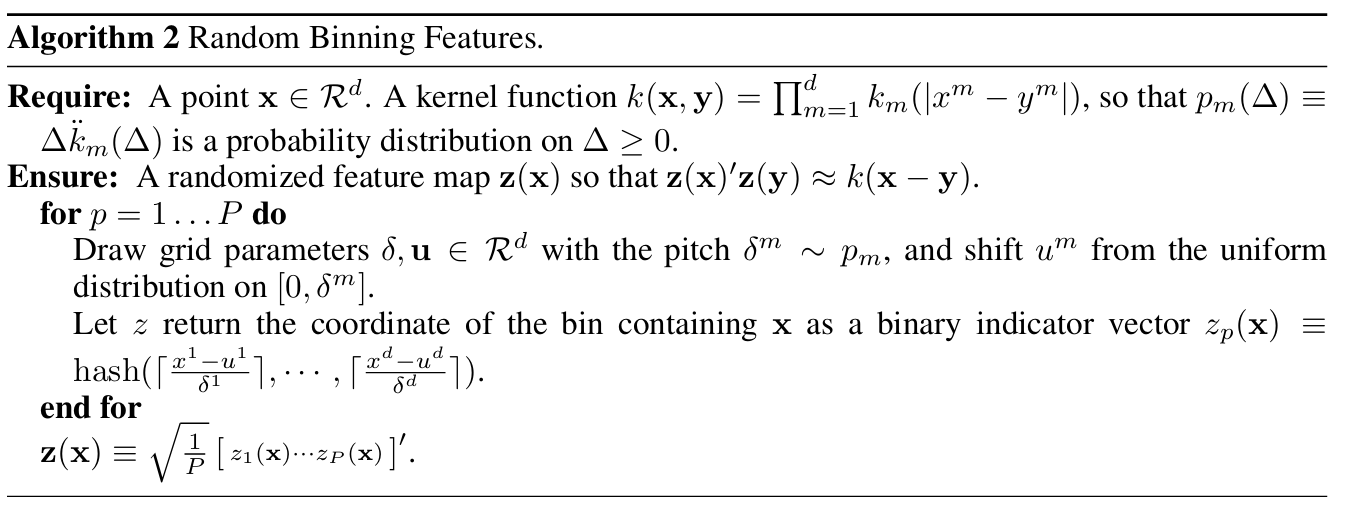

*RBF:*

In [5]:
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomBinningFeatureCreator)
pipeline.fit(x_train[:5000], y_train[:5000])
y_pred = pipeline.predict(x_test[:5000])
accuracy = sum(y_pred == y_test[:5000])/len(y_test[:5000])*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке: 80.96%


*RFF:*

In [6]:
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator)
pipeline.fit(x_train[:5000], y_train[:5000])
y_pred = pipeline.predict(x_test[:5000])
accuracy = sum(y_pred == y_test[:5000])/len(y_test[:5000])*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке: 84.0%


*ORF:*

In [7]:
pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=OrthogonalRandomFeatureCreator)
pipeline.fit(x_train[:5000], y_train[:5000])
y_pred = pipeline.predict(x_test[:5000])
accuracy = sum(y_pred == y_test[:5000])/len(y_test[:5000])*100
print(f'Доля верных ответов на тестовой выборке: {round(accuracy, 2)}%')

Доля верных ответов на тестовой выборке: 83.84%


**Вывод:** Данный метод обучается очень долго, поэтому я использовал подвыборку из 5000 объектов. По результатам можно сделать вывод, что метод RBF хоть и дает высокое качество, но на 3% ниже, чем RFF и ORF. Также стоит учесть, что время обучения и применения у RBF намного больше.

__Задание 6. (Максимум 2.5 балла)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск **[1 балл максимум]**, также добавьте возможность использовать аналитическую формулу **[1 балл максимум]**. Для градиентного спуска выпишите градиент ниже **[0.5 баллов максимум]**.
Подумайте о том, как в формулах правильно учесть свободный коэффициент.

Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь:
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание:
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

___Выведите градиент:___
$$
\nabla Q(w) = \Phi \Phi^T(\Phi \Phi^T w - y) + \lambda \Phi \Phi^T w
$$

Вы можете изменять представленный шаблон в файле `homework_practice_08_kernel_regression.py` по своему усмотрению.

In [67]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.gaussian_process.kernels import RBF


class KernelRidgeRegression(RegressorMixin):
    """
    Kernel Ridge regression class
    """

    def __init__(
        self,
        lr=0.01,
        regularization=1.0,
        tolerance=1e-2,
        max_iter=1000,
        batch_size=64,
        kernel_scale=1.0,
    ):
        """
        :param lr: learning rate
        :param regularization: regularization coefficient
        :param tolerance: stopping criterion for square of euclidean norm of weight difference
        :param max_iter: stopping criterion for iterations
        :param batch_size: size of the batches used in gradient descent steps
        :parame kernel_scale: length scale in RBF kernel formula
        """

        self.lr: float = lr
        self.regularization: float = regularization
        self.w: np.ndarray | None = None

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter
        self.batch_size: int = batch_size
        self.loss_history: list[float] = []
        self.kernel = RBF(kernel_scale)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        K = self.kernel(x)
        loss = 1/2*(np.linalg.norm(K @ self.w - y))**2 + self.regularization/2 * (self.w[:-1].T @ K[:-1,:-1] @ self.w[:-1])
        return loss

    def calc_grad(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating gradient for x and y dataset
        :param x: features array
        :param y: targets array
        """
        K = self.kernel(x)
        grad = K @ (K @ self.w[self.indexes] - y) + self.regularization * (K @ self.w[self.indexes])
        return grad

    def fit(self, x: np.ndarray, y: np.ndarray) -> "KernelRidgeRegression":
        """
        Получение параметров с помощью градиентного спуска
        :param x: features array
        :param y: targets array
        :return: self
        """
        K = self.kernel(x)
        self.X_train = x
        n_samples = x.shape[0]
        self.w = np.zeros(n_samples)
        for iter in range(self.max_iter):
            self.indexes = np.random.choice(n_samples-1, self.batch_size, replace=True)
            x_batch = x[self.indexes]
            y_batch = y[self.indexes]
            grad = self.calc_grad(x_batch, y_batch)
            self.w[self.indexes] -= self.lr*grad

            loss = self.calc_loss(x, y)
            self.loss_history.append(loss)

            if np.linalg.norm(grad) < self.tolerance:
                break

        return self.loss_history

    def fit_closed_form(self, x: np.ndarray, y: np.ndarray) -> "KernelRidgeRegression":
        """
        Получение параметров через аналитическое решение
        :param x: features array
        :param y: targets array
        :return: self
        """
        K = self.kernel(x)
        self.X_train = x
        self.w = np.linalg.inv(K + self.regularization * np.eye(K.shape[0])) @ y
        return self

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        K = self.kernel(x, self.X_train)
        return K @ self.w

*Синтетические данные:*

Чтобы учесть свободный коэффициент, я добавил столбец из единиц к матрицам x, но bias регулизовать не нужно, поэтому я убрал последний вес при подсчете лосса и градиента в слагаемом с регуляризацией.

In [3]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

x, y = make_regression(n_samples=1000, n_features=100, noise=10)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

x_train_with_constant = np.hstack([x_train, np.ones([x_train.shape[0], 1])])
x_test_with_constant = np.hstack([x_test, np.ones([x_test.shape[0], 1])])

**KernelRidgeRegression (градиентный спуск):**

In [109]:
KRR = KernelRidgeRegression(max_iter=2000, lr=0.05, regularization=0.1, kernel_scale=5)
losses = KRR.fit(x_train_with_constant, y_train)
y_pred = KRR.predict(x_test_with_constant)
mse = sum((y_pred - y_test)**2)/len(y_test)
print(f'MSE на тестовой выборке: {round(mse, 2)}')

MSE на тестовой выборке: 15134.77


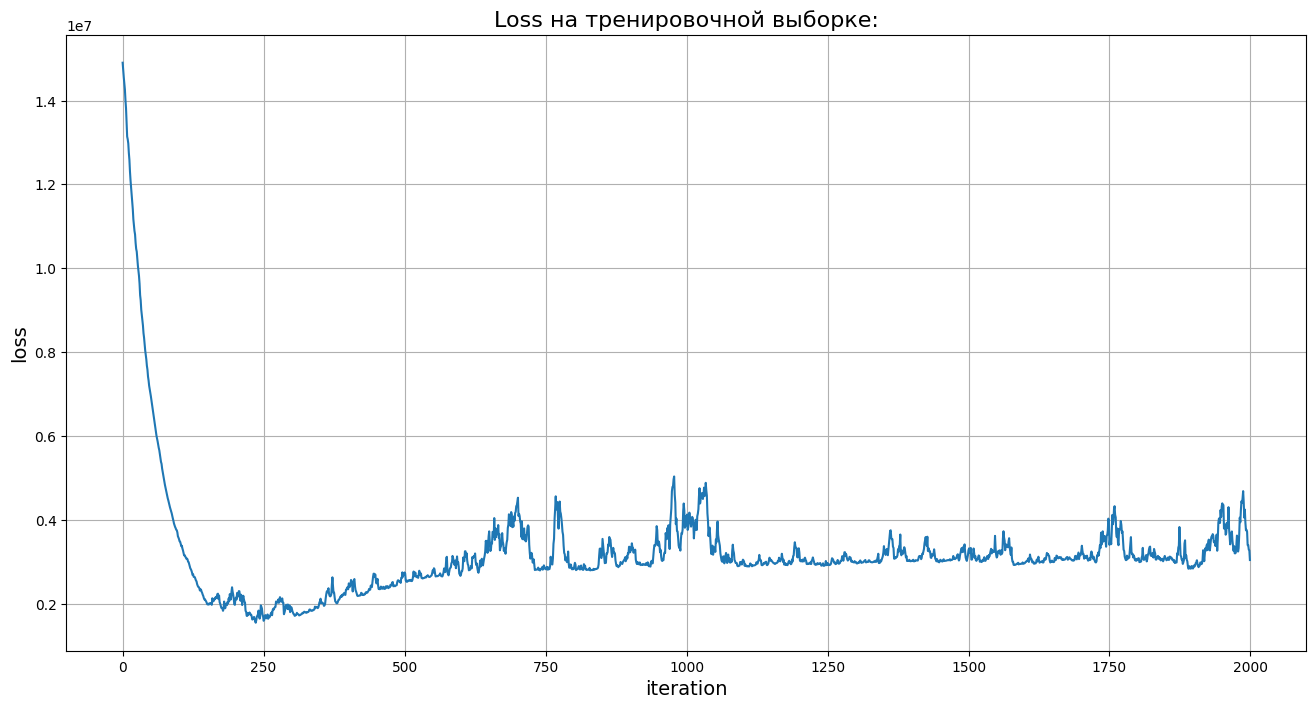

In [110]:
plt.figure(figsize=(16, 8))
plt.plot(losses)

plt.title('Loss на тренировочной выборке:', fontsize=16)
plt.xlabel('iteration', fontsize=14)
plt.ylabel('loss', fontsize=14)

plt.grid(True)

**KernelRidgeRegression (аналитическая формула):**

In [70]:
for kernel_scale in [1, 3, 5, 7, 10, 12, 15, 20]:
    KRR = KernelRidgeRegression(kernel_scale=kernel_scale)
    KRR.fit_closed_form(x_train_with_constant, y_train)
    y_pred = KRR.predict(x_test_with_constant)
    mse = sum((y_pred - y_test)**2)/len(y_test)
    print(f'MSE на тестовой выборке при kernel_scale = {kernel_scale}: {round(mse, 2)}')

MSE на тестовой выборке при kernel_scale = 1: 41448.14
MSE на тестовой выборке при kernel_scale = 3: 41330.48
MSE на тестовой выборке при kernel_scale = 5: 25783.21
MSE на тестовой выборке при kernel_scale = 7: 10760.02
MSE на тестовой выборке при kernel_scale = 10: 6028.67
MSE на тестовой выборке при kernel_scale = 12: 5762.48
MSE на тестовой выборке при kernel_scale = 15: 6586.57
MSE на тестовой выборке при kernel_scale = 20: 9303.57


In [88]:
for regularization in [0.001, 0.005, 0.01, 0.05, 0.1]:
    KRR = KernelRidgeRegression(kernel_scale=12, regularization=regularization)
    KRR.fit_closed_form(x_train_with_constant, y_train)
    y_pred = KRR.predict(x_test_with_constant)
    mse = sum((y_pred - y_test)**2)/len(y_test)
    print(f'MSE на тестовой выборке при regularization = {regularization}: {round(mse, 2)}')

MSE на тестовой выборке при regularization = 0.001: 461.1
MSE на тестовой выборке при regularization = 0.005: 472.55
MSE на тестовой выборке при regularization = 0.01: 487.25
MSE на тестовой выборке при regularization = 0.05: 618.04
MSE на тестовой выборке при regularization = 0.1: 807.78


**RFF + RidgeRegression:**

In [74]:
from sklearn.linear_model import Ridge


for n_features in [100, 250, 500, 750, 1000, 2500, 5000, 10000, 20000, 30000, 40000, 50000, 75000]:
    pipeline = RFFPipeline(n_features=n_features, feature_creator_class=RandomFeatureCreator, classifier_class=Ridge, use_PCA=False)
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    mse = sum((y_pred - y_test)**2)/len(y_test)
    print(f'MSE на тестовой выборке при n_features = {n_features}: {round(mse, 2)}')

MSE на тестовой выборке при n_features = 100: 25524.41
MSE на тестовой выборке при n_features = 250: 9163.15
MSE на тестовой выборке при n_features = 500: 5244.26
MSE на тестовой выборке при n_features = 750: 3778.32
MSE на тестовой выборке при n_features = 1000: 2241.31
MSE на тестовой выборке при n_features = 2500: 771.17
MSE на тестовой выборке при n_features = 5000: 577.9
MSE на тестовой выборке при n_features = 10000: 374.75
MSE на тестовой выборке при n_features = 20000: 342.63
MSE на тестовой выборке при n_features = 30000: 332.33
MSE на тестовой выборке при n_features = 40000: 331.53
MSE на тестовой выборке при n_features = 50000: 328.75
MSE на тестовой выборке при n_features = 75000: 307.68


**Вывод:** RFF показывает результаты лучше, благодаря подбору количества новых признаков. Даже если подбирать оптимальные параметры в ядровой регрессии, все равно MSE будет выше, чем у RFF, для которого мы изменяли только параметр n_features, а коэффициент регуляризации не трогали. Все-таки большое количество случайных признаков сильно улучшает качество.